1. Import Dependencies & Modules

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import config

from src.model_training import (
    prepare_features_targets,
    train_and_tune_rf,
    evaluate_model,
    plot_results
)
from src.data_processing import extract_molecular_data, process_molecular_csv

sns.set(style="whitegrid")

INFO: Enabling RDKit 2024.09.2 jupyter extensions


2. Data Processing

In [2]:
raw_dir = os.path.join(config.RAW_DATA_DIR, "PhotochemCAD", "Common Compounds")
processed_dir = config.PROCESSED_DATA_DIR
os.makedirs(processed_dir, exist_ok=True)

molecular_csv = config.MOLECULAR_DATA_CSV
train_csv = config.TRAIN_DATA_CSV
test_csv = config.TEST_DATA_CSV

# Step 1: Extract data from raw files to generate molecular_data.csv
extract_molecular_data(raw_dir, molecular_csv, max_peaks=config.MAX_PEAKS)

# Step 2: Process molecular_data.csv to generate training and test CSVs
process_molecular_csv(molecular_csv, train_csv, test_csv)

Extracting molecular data: 100%|██████████| 338/338 [03:51<00:00,  1.46file/s]
INFO: 294/338 molecules successfully processed.
[17:06:09] WARNING: not removing hydrogen atom without neighbors
[17:06:09] WARNING: not removing hydrogen atom without neighbors
[17:06:09] WARNING: not removing hydrogen atom without neighbors


3. Load Training & Test Data

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (235, 3)
Test data shape: (59, 3)


4. Prepare Features and Targets

In [4]:
X_train, X_test, y_train, y_test = prepare_features_targets(train_df, test_df)
print("Features prepared:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

INFO: X_train shape: (235, 1024), X_test shape: (59, 1024)


Features prepared:
X_train shape: (235, 1024)
X_test shape: (59, 1024)


5. Train the Model

In [5]:
best_model = train_and_tune_rf(X_train, y_train)
print("Model trained")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=78, max_features=0.3007, min_samples_split=2, n_estimators=134; total time=   0.2s
[CV] END bootstrap=True, max_depth=78, max_features=0.3007, min_samples_split=2, n_estimators=134; total time=   0.2s
[CV] END bootstrap=True, max_depth=78, max_features=0.3007, min_samples_split=2, n_estimators=134; total time=   0.2s
[CV] END bootstrap=True, max_depth=78, max_features=0.3007, min_samples_split=2, n_estimators=134; total time=   0.2s
[CV] END bootstrap=True, max_depth=78, max_features=0.3007, min_samples_split=2, n_estimators=134; total time=   0.2s


INFO: Best parameters: {'bootstrap': True, 'max_depth': 78, 'max_features': 0.3007, 'min_samples_split': 2, 'n_estimators': 134}


Model trained


6. Evaluate the Model

In [8]:
y_pred, mse, r2, mae_ev = evaluate_model(best_model, X_test, y_test)

INFO: Test MSE (wavelength): 7458.4556 nm²
INFO: Test R²: 0.7039
INFO: Test MAE (energy): 0.7663 eV


7. Visualize the Results

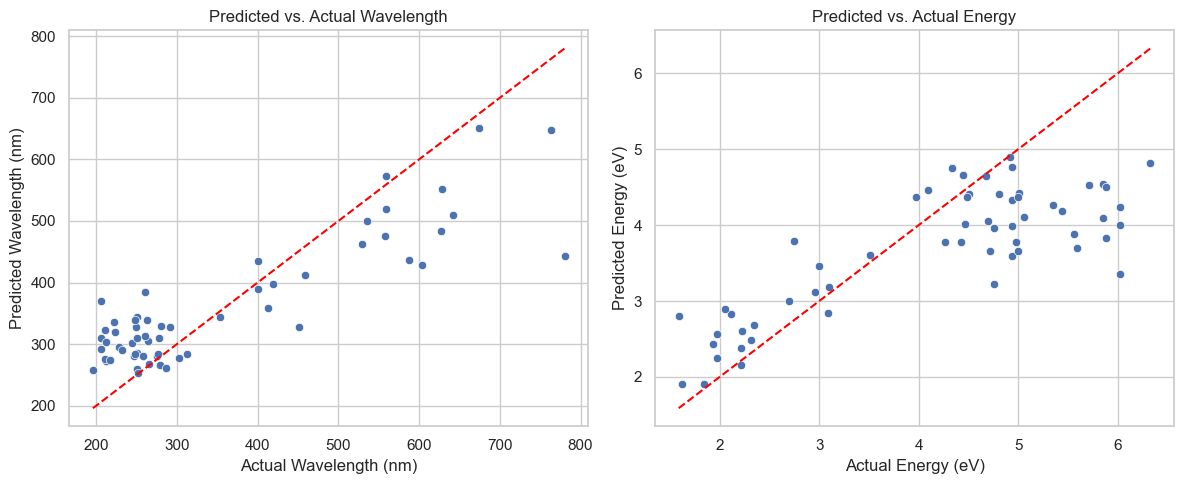

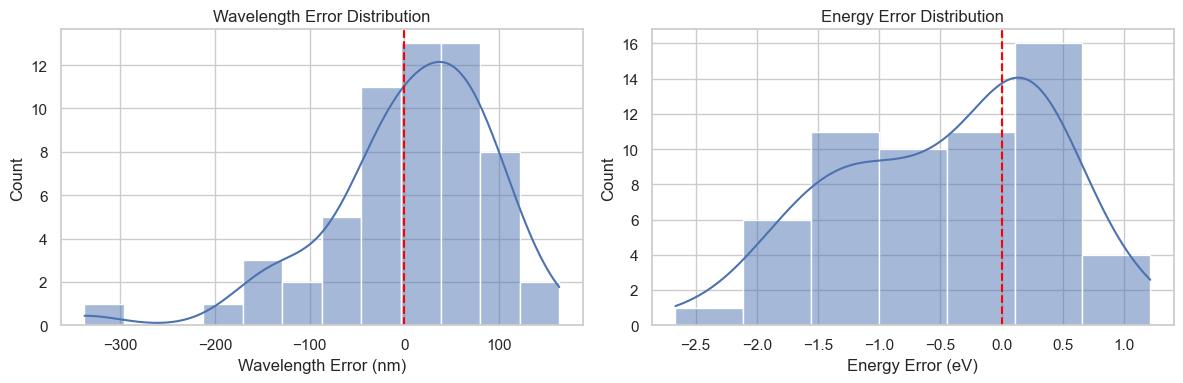

In [9]:
plot_results(y_test, y_pred)